## Modelo de regresion lineal sin los supuestos clasicos
Debido a que los supuestos en muchos casos suelen ser muy específicos, existen casos en los que se encuentra que no se cumplen con estos supuestos. Por ello, es importante saber identificarlos y encontrar una solucion a los siguientes:
1. Heterocedasticidad: varianza cambiante en el tiempo (supuesto 3)
2. Autocorrelacion: correlacion con rezagos (supuesto 3)
3. Endogeneidad en los regresores: correlacion de un regresor con el error (supuesto 2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

# Heterocedasticidad
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.linalg import toeplitz

# Autocorrelacion
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson

# Variables instrumentales
from statsmodels.sandbox.regression.gmm import IV2SLS

import warnings
warnings.simplefilter("ignore")

### Heterocedasticidad
Se usara la base de datos "US Census Bureau", un censo realizado en EE. UU. para recoger informacion sobre factores socioeconomicos. La endogena es la `cantidad de personas en situacion de pobreza` y las exogenas son la `edad`, `porcentaje con colegio`, y `tasa de disponibilidad de propietarios de viviendas`

In [2]:
url = "https://gist.githubusercontent.com/sachinsdate/0b8ebc2b26afb67a1e83e752c69e1a25/raw/43b\
568aa2e29af519720a4a63c83d49b0529d05d/us_census_bureau_acs_2015_2019_subset.csv"

df = pd.read_csv(url)
df.to_csv("./data/us_census.csv")

df.rename(
    {"Percent_Households_Below_Poverty_Level": "poverty",
    "Median_Age": "age",
    "Homeowner_Vacancy_Rate": "vacancy",
    "Percent_Pop_25_And_Over_With_College_Or_Higher_Educ": "educ"},
    axis=1, inplace=True
)

df = df.dropna()

df.head()

,County,poverty,age,vacancy,educ
0,"Autauga, Alabama",14.7,38.2,1.4,26.6
1,"Baldwin, Alabama",10.5,43.0,3.3,31.9
2,"Barbour, Alabama",27.5,40.4,3.8,11.6
3,"Bibb, Alabama",18.4,40.9,1.5,10.4
4,"Blount, Alabama",14.2,40.7,0.7,13.1


In [3]:
X = df[["age", "vacancy", "educ"]]
y = df["poverty"]

model = sm.OLS(y, X)
results = model.fit()

store_params_ols = results.params
store_covar_ols = results.normalized_cov_params

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                poverty   R-squared (uncentered):                   0.782
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              3850.
Date:                Sun, 01 Jan 2023   Prob (F-statistic):                        0.00
Time:                        20:28:30   Log-Likelihood:                         -11327.
No. Observations:                3219   AIC:                                  2.266e+04
Df Residuals:                    3216   BIC:                                  2.268e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Se puede definir la existencia de heterocedasticidad mediante lo siguiente:
1. Analisis grafico de los residuos
2. Test de White
3. Test de Breusch-Pagan

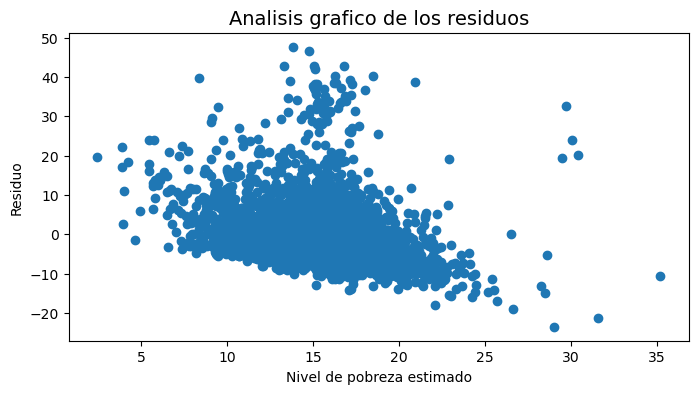

In [4]:
# Test 1
y_hat = results.predict(X)
residuos = results.resid

plt.figure(figsize=(8, 4))
plt.scatter(y_hat, residuos)

plt.title("Analisis grafico de los residuos", fontsize=14)
plt.xlabel("Nivel de pobreza estimado")
plt.ylabel("Residuo")

plt.show()

In [5]:
# Test 3
residuos = results.resid

test = het_breuschpagan(residuos, results.model.exog)
test = np.round(test, 3)

# H0: homocedasticidad en los errores
# H1: heterocedasticiadad en los erroes

print(f"El estadistico es {test[0]} y el p-value es {test[1]}")

El estadistico es 375.847 y el p-value es 0.0


Para solucionar el problema de heterocedasticidad se puede estimar por `Minimos Cuadrados Generalizados`

In [6]:
residuos = results.resid

eX = residuos[:-1].reset_index(drop=True)
eY = residuos[1:].reset_index(drop=True)

residuos_fit = sm.OLS(eY, eX).fit()
rho = residuos_fit.params[0]

order = toeplitz(np.arange(3219))
sigma = rho**order

In [7]:
model = sm.GLS(y, X, sigma=sigma)
results = model.fit()

store_params_gls = results.params
store_covar_gls = results.normalized_cov_params

print(results.summary())

                                 GLS Regression Results                                
Dep. Variable:                poverty   R-squared (uncentered):                   0.516
Model:                            GLS   Adj. R-squared (uncentered):              0.516
Method:                 Least Squares   F-statistic:                              1145.
Date:                Sun, 01 Jan 2023   Prob (F-statistic):                        0.00
Time:                        20:28:34   Log-Likelihood:                         -10768.
No. Observations:                3219   AIC:                                  2.154e+04
Df Residuals:                    3216   BIC:                                  2.156e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Comparativa de los parametros:

In [8]:
params = pd.DataFrame(
    data = {
        "OLS": store_params_ols,
        "GLS": store_params_gls
    }
)

params

,OLS,GLS
age,0.397883,0.365572
vacancy,0.873277,0.343937
educ,-0.138533,-0.098078


Comparativa de las matrices de covarianzas de los errores

In [9]:
print("Covarianza de errores de OLS")
print(store_covar_ols)
print("")
print("Covarianza de errores de por GLS")
print(store_covar_gls)

Covarianza de errores de OLS
              age   vacancy      educ
age      0.000001 -0.000008 -0.000002
vacancy -0.000008  0.000152  0.000001
educ    -0.000002  0.000001  0.000003

Covarianza de errores de por GLS
                  age   vacancy          educ
age      1.215634e-06 -0.000005 -9.532662e-07
vacancy -5.116471e-06  0.000094  1.168863e-06
educ    -9.532662e-07  0.000001  1.950414e-06


### Autocorrelacion
Se usara las series macroeconomicas de los Estados Unidos

In [10]:
dta = sm.datasets.macrodata.load_pandas()
dta.data.to_csv("./data/macrodata.csv")

dta.data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [11]:
X = dta.data[["realgdp"]]; y = dta.data["cpi"]
X = np.log(X); y = np.log(y)

X = X.diff(periods=4)*100; X = X.dropna()
y = y.diff(periods=4)*100; y = y.dropna()

# Añadir constante
X = sm.add_constant(X)

In [12]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     7.333
Date:                Sun, 01 Jan 2023   Prob (F-statistic):            0.00737
Time:                        20:28:34   Log-Likelihood:                -480.93
No. Observations:                 199   AIC:                             965.9
Df Residuals:                     197   BIC:                             972.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7062      0.324     14.526      0.0

Se puede definir la existencia de autocorrelacion mediante lo siguiente:
1. ACF, PACF
2. Test de Durbin-Watson
3. Test de Breusch-Pagan

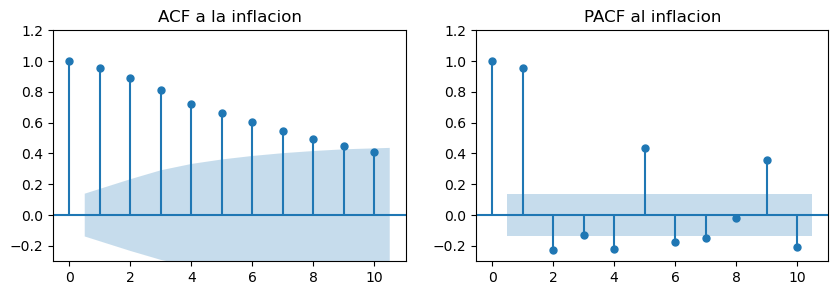

In [13]:
# Test 1
fig, ax = plt.subplots(1, 2, figsize=(10,3))

plot_acf(y, ax=ax[0], lags=10, title="ACF a la inflacion", alpha=0.05)
plot_pacf(y, ax=ax[1], lags=10, title="PACF al inflacion", alpha=0.05)

ax[0].set_ylim([-0.3, 1.2])
ax[1].set_ylim([-0.3, 1.2])

plt.subplots_adjust()
plt.savefig("./figures/acf_pacf_inflac.pdf")
plt.show()

In [14]:
# Test 2
np.round(durbin_watson(results.resid), 3) # Autocorrelacion positiva

0.097

In [15]:
# Test 3
def test_breusch_godfrey(model_results, maxlags):
    list = []

    for i in range(1, maxlags+1):
        values = acorr_breusch_godfrey(model_results, nlags=i)
        list.append([i, values[0], values[1]])
    
    table = pd.DataFrame(list, columns=["lags", "LM", "pvalue"])
    table.set_index("lags", inplace=True)
    
    # P-value < pvalue 
    table[f"pv<0.1"] = table["pvalue"]<0.1
    table[f"pv<0.05"] = table["pvalue"]<0.05
    table[f"pv<0.01"] = table["pvalue"]<0.01

    # Rounding
    table["LM"] = np.round(table["LM"], 3)
    table["pvalue"] = np.round(table["pvalue"], 3)

    return table


# La hipotesis nula es de no autocorrelacion
# Se rechaza la no autocorrelacion hasta 5 rezagos. 
test_breusch_godfrey(results, maxlags=5)

,LM,pvalue,pv<0.1,pv<0.05,pv<0.01
lags,,,,,
1,182.526,0.0,True,True,True
2,182.526,0.0,True,True,True
3,182.530,0.0,True,True,True
4,182.869,0.0,True,True,True
5,184.772,0.0,True,True,True


Inclusión de un rezago

In [16]:
X = dta.data[["realgdp"]]; y = dta.data["cpi"]
X = np.log(X); y = np.log(y)

X = X.diff(periods=4)*100 
y = y.diff(periods=4)*100

X["cpi(-1)"] = y.shift(1) # Añadiendo un rezago
X = X.dropna(); y = y.dropna()

# Añadir constante
X = sm.add_constant(X)

y = y[1:]

In [17]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     1271.
Date:                Sun, 01 Jan 2023   Prob (F-statistic):          1.41e-112
Time:                        20:28:35   Log-Likelihood:                -220.83
No. Observations:                 198   AIC:                             447.7
Df Residuals:                     195   BIC:                             457.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3262      0.135     -2.420      0.0

In [18]:
print("Parece solucionar un poco la autocorrelacion en los dos primeros rezagos")
test_breusch_godfrey(results, maxlags=3)

Parece solucionar un poco la autocorrelacion en los dos primeros rezagos


,LM,pvalue,pv<0.1,pv<0.05,pv<0.01
lags,,,,,
1,0.563,0.453,False,False,False
2,3.988,0.136,False,False,False
3,12.778,0.005,True,True,True


### Endogeneidad
Para el analisis de endogeneidad se usara la base de datos `smoke` del libro de Wooldridge. Esta base de datos contiene informacion sobre los efectos del tabaquismo sobre los ingresos anuales

In [19]:
dta = pd.read_stata("./data/smoke.dta")
dta.head()

,educ,cigpric,white,age,income,cigs,restaurn,lincome,agesq,lcigpric
0,16.0,60.506001,1,46,20000,0,0,9.903487,2116,4.102743
1,16.0,57.882999,1,40,30000,0,0,10.308952,1600,4.058424
2,12.0,57.664001,1,58,30000,3,0,10.308952,3364,4.054633
3,13.5,57.882999,1,30,20000,0,0,9.903487,900,4.058424
4,10.0,58.320000,1,17,20000,0,0,9.903487,289,4.065945


In [20]:
X = dta[["cigs", "educ", "age", "agesq"]]
X = sm.add_constant(X)
y = dta["lincome"]

In [21]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                lincome   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     39.61
Date:                Sun, 01 Jan 2023   Prob (F-statistic):           2.68e-30
Time:                        20:28:35   Log-Likelihood:                -798.50
No. Observations:                 807   AIC:                             1607.
Df Residuals:                     802   BIC:                             1630.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7954      0.170     45.741      0.0

Se encuentra que los resultados dan como signo positvo al consumo de cigarros sobre los ingresos. Por el contrario, se espera que haya una relacion negativa. Posiblemente estemos dejando de lado la simultaneidad que tiene el consumo con los precios. Se usara los instrumentos de `cigpric` y `restaurn`

In [22]:
X_inst = dta[["educ", "age", "agesq", "cigpric", "restaurn"]]
X_inst = sm.add_constant(X_inst)
y_inst = dta["cigs"]

model_inst = sm.OLS(y_inst, X_inst)
results_inst = model_inst.fit()

print(results_inst.summary())

                            OLS Regression Results                            
Dep. Variable:                   cigs   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     8.610
Date:                Sun, 01 Jan 2023   Prob (F-statistic):           5.87e-08
Time:                        20:28:35   Log-Likelihood:                -3237.0
No. Observations:                 807   AIC:                             6486.
Df Residuals:                     801   BIC:                             6514.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0204      6.861     -0.003      0.9

In [23]:
dta["cigs_hat"] = results_inst.predict(X_inst)
dta.head()

,educ,cigpric,white,age,income,cigs,restaurn,lincome,agesq,lcigpric,cigs_hat
0,16.0,60.506001,1,46,20000,0,0,9.903487,2116,4.102743,10.484249
1,16.0,57.882999,1,40,30000,0,0,10.308952,1600,4.058424,10.490481
2,12.0,57.664001,1,58,30000,3,0,10.308952,3364,4.054633,10.179045
3,13.5,57.882999,1,30,20000,0,0,9.903487,900,4.058424,10.105997
4,10.0,58.320000,1,17,20000,0,0,9.903487,289,4.065945,6.853313


In [24]:
X = dta[["cigs_hat", "educ", "age", "agesq"]]
X = sm.add_constant(X)
y = dta["lincome"]


model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                lincome   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     40.64
Date:                Sun, 01 Jan 2023   Prob (F-statistic):           4.92e-31
Time:                        20:28:35   Log-Likelihood:                -796.78
No. Observations:                 807   AIC:                             1604.
Df Residuals:                     802   BIC:                             1627.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7813      0.170     45.723      0.0

De esta manera se corrige el signo y la endogeneidad. Una forma mas reducida de realizar esta estimacion es mediante `IV2SLS`

In [25]:
X = dta[["cigs", "educ", "age", "agesq"]]
X = sm.add_constant(X)
y = dta["lincome"]
instr = dta[["educ", "age", "agesq", "cigpric", "restaurn"]]

# Modelo
model = IV2SLS(y, X, instr)
results = model.fit()

print(results.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                lincome   R-squared:                      -0.464
Model:                         IV2SLS   Adj. R-squared:                 -0.471
Method:                     Two Stage   F-statistic:                     16.23
                        Least Squares   Prob (F-statistic):           8.69e-13
Date:                Sun, 01 Jan 2023                                         
Time:                        20:28:35                                         
No. Observations:                 807                                         
Df Residuals:                     802                                         
Df Model:                           4                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9470      0.263     30.266      0.0

### Referencias:
* https://www.statsmodels.org/dev/diagnostic.html
* https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.GLS.html#statsmodels.regression.linear_model.GLS